In [72]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import set_dark_theme

import skforecast
import sklearn
import lightgbm
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

import warnings

from skforecast.exceptions import LongTrainingWarning

random_state=12345

warnings.simplefilter('ignore')

In [73]:
color = "\033[1m\033[38;5;208m"
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.13.0
Versión scikit-learn: 1.5.1
Version lightgbm: 4.5.0
Versión pandas: 2.2.2
Versión numpy: 1.26.4


In [74]:
data = pd.read_csv('ethereum_2015-08-07_2024-06-28.csv')
data['End'] = pd.to_datetime(data['End'])
data = data.set_index('End')
data = data.drop(columns = ['Start'])
data = data.asfreq('D')
data

,Open,High,Low,Close,Volume,Market Cap
End,,,,,,
2015-08-09,2.772120,2.798810,0.714725,0.714876,3.141436e+05,1.039569e+08
2015-08-10,0.753325,0.879810,0.629191,0.729347,6.998264e+05,4.156260e+07
2015-08-11,0.701897,0.729854,0.636546,0.707703,4.577479e+05,4.182758e+07
2015-08-12,0.708448,1.131410,0.663235,1.057670,6.406322e+05,4.768204e+07
2015-08-13,1.067860,1.289940,0.883608,1.237670,1.971841e+06,6.682610e+07
...,...,...,...,...,...,...
2024-06-24,3523.068200,3544.824700,3443.023700,3443.023700,9.130649e+09,4.220809e+11
2024-06-25,3441.330600,3451.157800,3262.511400,3363.763500,1.952047e+10,4.033384e+11
2024-06-26,3361.433500,3430.000800,3345.159300,3408.774000,2.211726e+10,4.075215e+11


In [75]:
print(f'Número de filas con valores ausentes: {data.isnull().any(axis=1).mean()}')

Número de filas con valores ausentes: 0.0


In [76]:
eth_halving = {
    "halving": [0,1,2,3,4],
    "date":["2009-01-03","2012-11-28","2016-07-09","2020-05-11", np.nan],
    "reward":[50,25,12.5,6.25,3.125],
    "halving_block_number":[0,210000,420000,630000,840000]
}

In [77]:
bloques_restantes = 121400
bloques_por_dia = 144
dias = bloques_restantes / bloques_por_dia
next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=dias)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')
eth_halving['date'][-1] = next_halving

print(f'El próximo halving ocurrirá aproximadamente el: {next_halving}')

El próximo halving ocurrirá aproximadamente el: 2024-05-06


In [78]:
data["reward"] = np.nan
data["countdown_halving"] = np.nan

for i in range(len(eth_halving["halving"]) - 1):

    # Fecha inicial y final de cada halving
    if eth_halving["date"][i] < data.index.min().strftime("%Y-%m-%d"):
        start_date = data.index.min().strftime("%Y-%m-%d")
    else:
        start_date = eth_halving["date"][i]

    end_date = eth_halving["date"][i + 1]
    mask = (data.index >= start_date) & (data.index < end_date)

    # Rellenar columna 'reward' con las recompensas de minería
    data.loc[mask, "reward"] = eth_halving["reward"][i]

    # Rellenar columna 'countdown_halving' con los días restantes
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)

    data.loc[mask, "countdown_halving"] = np.arange(time_to_next_halving.days)[::-1][
        : mask.sum()
    ]

In [79]:
print("Segundo halving:", eth_halving["date"][2])
display(data.loc["2016-07-08":"2016-07-09"])
print("")
print("Tercer halving:", eth_halving["date"][3])
display(data.loc["2020-05-10":"2020-05-11"])
print("")
print("Próximo halving:", eth_halving["date"][4])
data.tail(2)

Segundo halving: 2016-07-09


,Open,High,Low,Close,Volume,Market Cap,reward,countdown_halving
End,,,,,,,,
2016-07-08,10.5289,10.5658,9.80321,10.0990,1.515422e+07,8.257321e+08,25.0,0.0
2016-07-09,10.1094,11.5248,9.96126,11.4059,1.420767e+07,8.586858e+08,12.5,1401.0



Tercer halving: 2020-05-11


,Open,High,Low,Close,Volume,Market Cap,reward,countdown_halving
End,,,,,,,,
2020-05-10,211.512145,214.396272,209.162247,210.611161,1.431268e+10,2.351293e+10,12.50,0.0
2020-05-11,210.372618,210.372618,181.920287,187.998004,1.769080e+10,2.094900e+10,6.25,1455.0



Próximo halving: 2024-05-06


,Open,High,Low,Close,Volume,Market Cap,reward,countdown_halving
End,,,,,,,,
2024-06-27,3405.1884,3432.3600,3347.8603,3381.2506,1.439138e+10,4.080268e+11,NaN,NaN
2024-06-28,3383.5292,3481.1707,3379.1649,3458.8487,1.580400e+10,4.116605e+11,NaN,NaN


In [80]:
candlestick = go.Candlestick(
    x=data.index,
    open=data.Open,
    close=data.Close,
    low=data.Low,
    high=data.High,
)

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width=800,
    height=350,
    title=dict(text="<b>Chart Eherum/USD</b>", font=dict(size=20)),
    yaxis_title=dict(text="Precio (USD)", font=dict(size=15)),
    margin=dict(l=10, r=20, t=80, b=20),
    shapes=[
        dict(
            x0=eth_halving["date"][2],
            x1=eth_halving["date"][2],
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line_width=2,
        ),
        dict(
            x0=eth_halving["date"][3],
            x1=eth_halving["date"][3],
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line_width=2,
        ),
        dict(
            x0=eth_halving["date"][4],
            x1=eth_halving["date"][4],
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line_width=2,
        ),
    ],
    annotations=[
        dict(
            x=eth_halving["date"][2],
            y=1,
            xref="x",
            yref="paper",
            showarrow=False,
            xanchor="left",
            text="Segundo halving",
        ),
        dict(
            x=eth_halving["date"][3],
            y=1,
            xref="x",
            yref="paper",
            showarrow=False,
            xanchor="left",
            text="Tercer halving",
        ),
        dict(
            x=eth_halving["date"][4],
            y=1,
            xref="x",
            yref="paper",
            showarrow=False,
            xanchor="left",
            text="Cuarto halving",
        ),
    ],
    xaxis_rangeslider_visible=False,
)

fig.show()

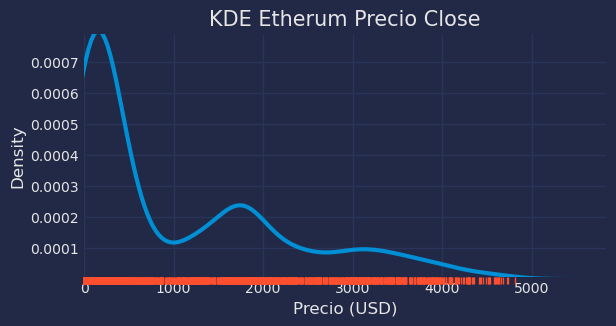

In [81]:
set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 3))
p = sns.kdeplot(data=data, x="Close", linewidth=3, ax=ax)
r = sns.rugplot(data=data, x="Close", ax=ax, height=-0.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title("KDE Etherum Precio Close", fontsize=15)
p.set_xlabel("Precio (USD)");

In [82]:
# Datos correspondientes por año

years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
  year_open = data.loc[data.index.year == year, "Open"].iloc[-1]
  year_close = data.loc[data.index.year ==year, "Close"].iloc[-1]
  year_low = data.loc[data.index.year == year, "Low"].min()
  year_high = data.loc[data.index.year == year, "High"].max()

  df_plot[year] = pd.Series([year_open, year_close, year_low, year_high])

df_plot = df_plot.T
df_plot = df_plot.set_axis(["Open","Close","Low","High"], axis=1)

# Porcentaje de cambio entre open y close

df_plot["year_change"] = 100 * (df_plot["Close"] - df_plot["Open"]) / df_plot["Open"]

df_plot

,Open,Close,Low,High,year_change
2015,0.873054,0.909437,0.420897,2.798810,4.167325
2016,8.284160,8.159880,0.910277,21.522700,-1.500212
2017,754.395698,699.268858,7.909380,878.429639,-7.307417
2018,136.906456,139.700316,82.409426,1570.126200,2.040708
2019,134.297836,131.650286,102.616444,365.133005,-1.971402
2020,731.317989,753.752104,93.028377,754.803258,3.067628
2021,3640.373261,3724.106300,718.063089,4867.173594,2.300122
2022,1201.761285,1199.671997,897.011206,3888.932141,-0.173852
2023,2302.385100,2307.432900,1193.422200,2447.600900,0.219242
2024,3383.529200,3458.848700,2146.266800,4094.175700,2.226063


In [83]:
# Lista con anotaciones de % de cambio

annotations_list = []
max_high = df_plot["High"].max()

for year in years:
  df_aux = df_plot.loc[df_plot.index == year,]
  loc_x = pd.to_datetime(df_aux.index[0], format="%Y")
  loc_y = df_aux["High"].values[0] / max_high + 0.05
  text = "{:.1f}%".format(df_aux["year_change"].values[0])

  annotaion = dict(
      x =loc_x,
      y= loc_y,
      xref = "x",
      yref = "paper",
      showarrow = False,
      xanchor = "center",
      text = text,
  )

  annotations_list.append(annotaion)

# Gráfico

candlestick = go.Candlestick(
    x = pd.to_datetime(df_plot.index, format="%Y"),
    open = df_plot.Open,
    close = df_plot.Close,
    low = df_plot.Low,
    high = df_plot.High,
)

fig = go.Figure(data = [candlestick])

fig.update_layout(
    width = 800,
    height = 350,
    title = dict(text = "<b>Chart Etherum/USD por año</b>", font = dict(size=20)),
    yaxis_title = dict(text="Precio (USD)", font = dict(size=13)),
    margin = dict(l=0,r=20,t=55,b=20),
    xaxis_rangeslider_visible=False,
    annotations=annotations_list,
)
fig.show()

# Estacionalidad anual, mensual y semanal

In [85]:
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
  for mes in range(12):

    star_date = pd.to_datetime(f"{year}-{mes+1}-01", format="%Y-%m-%d")
    end_date = star_date + pd.offsets.MonthBegin()
    mask = (data.index >= start_date) & (data.index < end_date)

    if not data.loc[mask, :].empty:
      month_open = data.loc[mask, "Open"].iloc[0]
      month_close = data.loc[mask, "Close"].iloc[-1]
      month_low = data.loc[mask, "Low"].min()
      month_high = data.loc[mask, "High"].max()

      serie = pd.Series([month_open, month_close, month_low, month_high])
      df_aux = pd.DataFrame(serie, columns=[f"{str(mes+1).zfill(2)}-{year}"])

      if df_plot.empty:
        df_plot = df_aux.copy()
      else:
        df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(["Open", "Close","Low","High"], axis=1)
df_plot.head()

,Open,Close,Low,High
05-2020,210.372618,242.460017,179.302871,244.411254
06-2020,210.372618,227.752305,179.302871,252.740673
07-2020,210.372618,334.319944,179.302871,339.176022
08-2020,210.372618,423.189465,179.302871,443.374015
09-2020,210.372618,359.528061,179.302871,479.491872


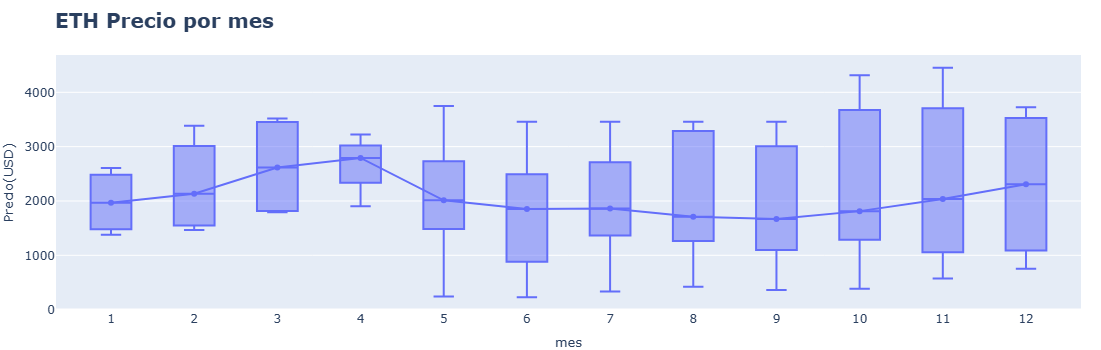

In [86]:
df_plot["mes"] = pd.to_datetime(df_plot.index, format="%m-%Y").month

fig1 = px.box(df_plot.sort_values("mes"), x="mes", y="Close")

df_median = pd.DataFrame(df_plot.groupby("mes")["Close"].median()).reset_index()
fig2 = px.line(df_median, x="mes", y="Close", markers=True)

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width = 650,
    height = 350,
    title = dict(text = "<b>ETH Precio por mes</b>", font = dict(size = 20)),
    yaxis_title = dict(text="Precio(USD)", font = dict( size = 13)),
    xaxis = dict(tickmode = "linear"),
    xaxis_title= dict(text = "mes", font = dict(size = 13)),
    margin = dict(l=0,r=20,t=55,b=20)
)

fig.show()

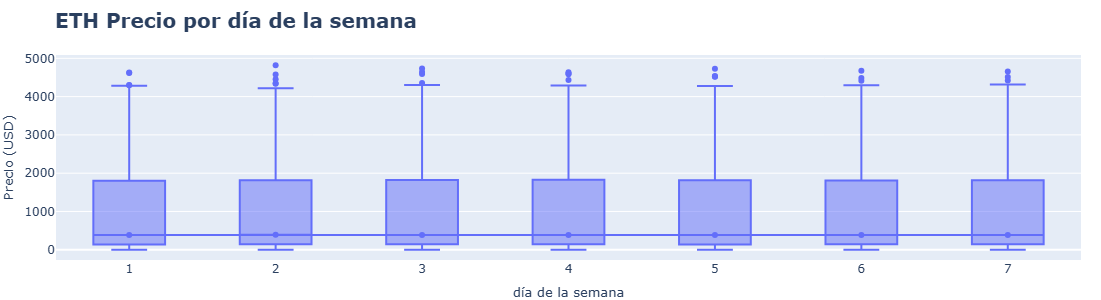

In [87]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
data["dia_semana"] = data.index.day_of_week + 1

# fig 1 boxplot de los días de la semana
fig1 = px.box(
    data.sort_values("dia_semana"),
    x="dia_semana",
    y="Close"
)

# fig 2 line con datos de la mediana los días de la semana
df_median = pd.DataFrame(data.groupby("dia_semana")["Close"].median()).reset_index()
fig2 = px.line(
    df_median,
    x="dia_semana",
    y="Close",
    markers=True
)

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width=600,
    height=300,
    title=dict(text="<b>ETH Precio por día de la semana</b>", font=dict(size=20)),
    yaxis_title=dict(text="Precio (USD)", font=dict(size=13)),
    xaxis=dict(tickmode="linear"),
    xaxis_title=dict(text="día de la semana", font=dict(size=13)),
    margin=dict(l=0, r=20, t=55, b=20),
)

fig.show()

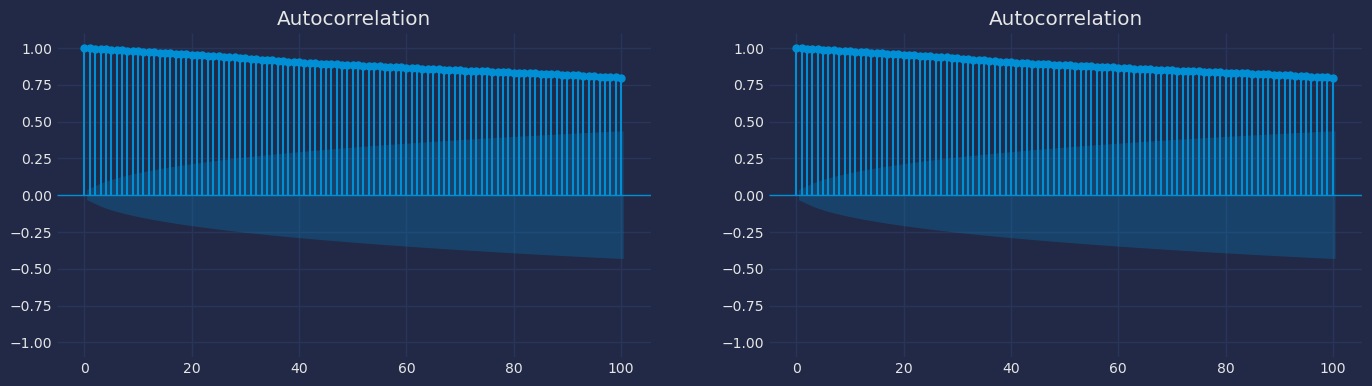

In [88]:
# Gráfico autocorrelación
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes = axes.flat
plot_acf(data.Close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.Close, ax=axes[1], linewidth = 1, lags=100)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

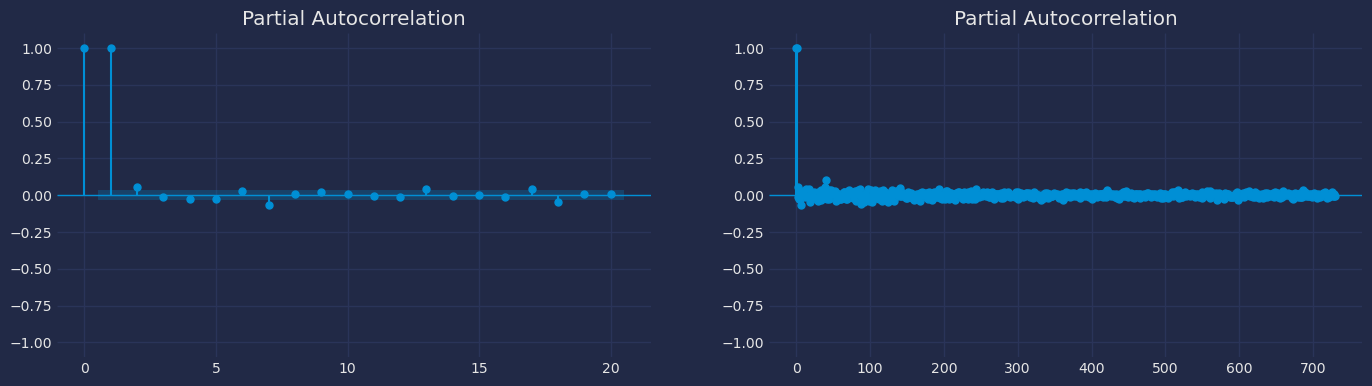

In [89]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes = axes.flat
plot_pacf(data.Close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.Close, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

In [90]:
# Selección fechas train-test
# ==============================================================================
inicio_train = '2020-01-01 00:00:00'
fin_train = '2021-06-30 23:59:59'

print(f"Serie temporal completa : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Fechas train            : {data.loc[inicio_train:fin_train].index.min()} --- {data.loc[inicio_train:fin_train].index.max()}  (n={len(data.loc[inicio_train:fin_train])})")
print(f"Fechas test             : {data.loc[fin_train:].index.min()} --- {data.loc[fin_train:].index.max()}  (n={len(data.loc[fin_train:])})")

Serie temporal completa : 2015-08-09 00:00:00 --- 2024-06-28 00:00:00  (n=3247)
Fechas train            : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00  (n=547)
Fechas test             : 2021-07-01 00:00:00 --- 2024-06-28 00:00:00  (n=1094)


In [91]:
# Simulación Random Walk
# ==============================================================================
df_rw = data[['Close']].copy()
df_rw['pred_close'] = df_rw['Close'].shift(1)

# Error de test
# ==============================================================================
y_true = df_rw.loc[fin_train:, 'Close']
y_pred = df_rw.loc[fin_train:, 'pred_close']
metrica = mean_absolute_error(y_true, y_pred)

print(f'Error de test: {metrica}')
display(df_rw.loc[fin_train:,].head(4))

Error de test: 61.66830106188736


,Close,pred_close
End,,
2021-07-01,2278.554228,2167.134094
2021-07-02,2122.900000,2278.554228
2021-07-03,2141.648345,2122.900000
2021-07-04,2232.173296,2141.648345


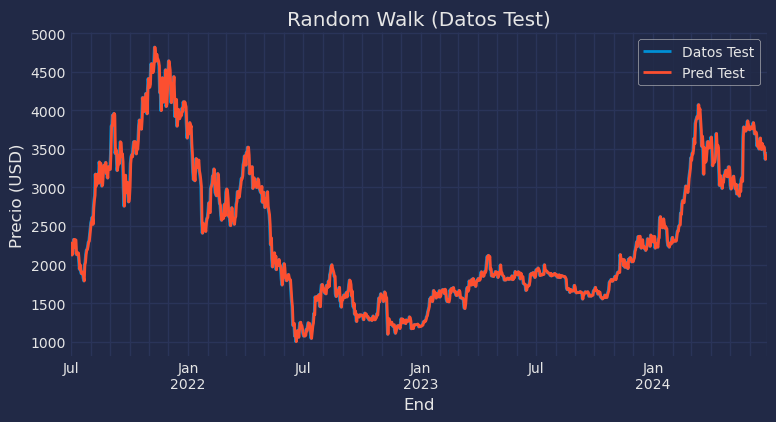

In [92]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 4))
df_rw.loc[fin_train:, "Close"].plot(ax=ax, linewidth=2, label="Datos Test")
df_rw.loc[fin_train:, "pred_close"].plot(ax=ax, linewidth=2, label="Pred Test")
ax.set_title("Random Walk (Datos Test)")
ax.set_ylabel("Precio (USD)")
ax.legend()

In [93]:
# DataFrame errores test modelos
# ==============================================================================
df_errores = pd.DataFrame({
        "modelo": "Base - Random Walk",
        "lags": 1,
        "error_test": metrica,
        "variables_exog": False,
    },
    index=[0],
)
df_errores

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,61.668301,False


In [94]:
# Backtest forecasters con diferentes lags
# ==============================================================================
lags = [1, 7, 30]
metricas = []
predicciones_list = []

for lag in lags:
    
    # Crear forecaster
    forecaster = ForecasterAutoreg(
                     regressor = LGBMRegressor(random_state=123, verbose=-1),
                     lags = lag,
                     transformer_y = None
                 )
    
    # Backtest test data 1 step
    metrica, predicciones = backtesting_forecaster(
                                forecaster = forecaster,
                                y = data.loc[inicio_train:, 'Close'],
                                initial_train_size = len(data.loc[inicio_train:fin_train,]),
                                fixed_train_size = True,
                                steps = 1,
                                refit = True,
                                metric = 'mean_absolute_error',
                                verbose = False,
                                show_progress = True,
                            )
    
    metricas.append(metrica.at[0, 'mean_absolute_error'])
    predicciones_list.append(predicciones)


  0%|          | 0/1094 [00:00<?, ?it/s]

  0%|          | 0/1094 [00:00<?, ?it/s]

  0%|          | 0/1094 [00:00<?, ?it/s]

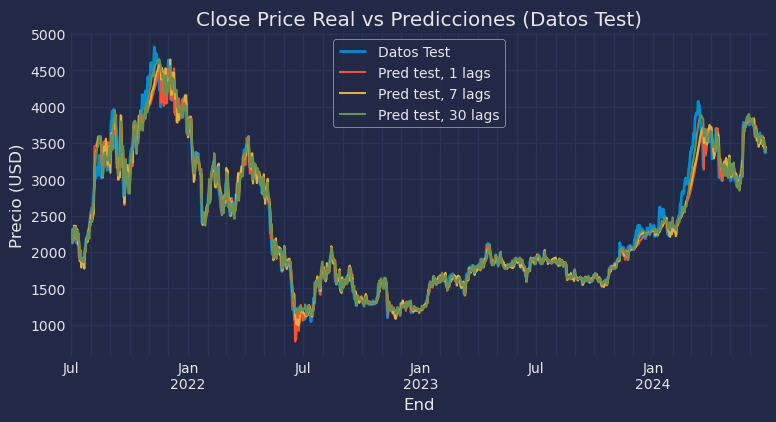

In [95]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 4))
data.loc[fin_train:, 'Close'].plot(ax=ax, linewidth=2, label='Datos Test')

# Plot predicciones test para diferentes lags
for predicciones, lag in zip(predicciones_list, lags):
    predicciones = predicciones.rename(columns={'pred': f'Pred test, {lag} lags'})
    predicciones.plot(ax=ax)

ax.set_title('Close Price Real vs Predicciones (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [96]:
# DataFrame errores de test modelos
# ==============================================================================
modelo = 'LGBMRegressor'
df_errores = pd.concat([
                df_errores,
                pd.DataFrame({
                    'modelo': modelo,
                    'lags': lags, 
                    'error_test': metricas,
                    'variables_exog': False
                })
             ]).reset_index(drop=True)
df_errores.sort_values(by='error_test')

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,61.668301,False
3,LGBMRegressor,30,89.605294,False
1,LGBMRegressor,1,93.351351,False
2,LGBMRegressor,7,98.248923,False


In [97]:
# One hot encoding de las variables categóricas
# ==============================================================================
data['mes'] = data.index.month
data = pd.get_dummies(data, columns=['reward', 'mes'], dtype=int)
data.head(2)

,Open,High,Low,Close,Volume,Market Cap,countdown_halving,dia_semana,reward_6.25,reward_12.5,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
End,,,,,,,,,,,,,,,,,,,,,
2015-08-09,2.772120,2.79881,0.714725,0.714876,314143.614583,1.039569e+08,334.0,7,0,0,...,0,0,0,0,0,1,0,0,0,0
2015-08-10,0.753325,0.87981,0.629191,0.729347,699826.371528,4.156260e+07,333.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [98]:
# Se seleccionan todas las variables exógenas, incluidas las obtenidas al hacer
# el one hot encoding
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])
exog

['reward_6.25',
 'reward_12.5',
 'reward_25.0',
 'mes_1',
 'mes_2',
 'mes_3',
 'mes_4',
 'mes_5',
 'mes_6',
 'mes_7',
 'mes_8',
 'mes_9',
 'mes_10',
 'mes_11',
 'mes_12',
 'countdown_halving']

In [99]:
# Backtest forecaster con variables exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags = 1,
                 transformer_y = None,
                 transformer_exog = None
             )

# Backtest test data 1 step
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y = data.loc[inicio_train:, 'Close'],
                            exog = data.loc[inicio_train:, exog],
                            initial_train_size = len(data.loc[inicio_train:fin_train,]),
                            fixed_train_size = True,
                            steps = 1,
                            refit = True,
                            metric = 'mean_absolute_error',
                            verbose = False,
                            show_progress = True
                        )

  0%|          | 0/1094 [00:00<?, ?it/s]

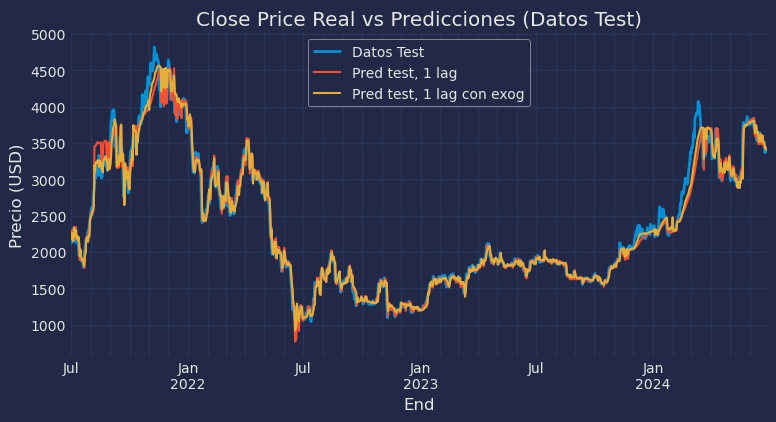

In [100]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 4))
data.loc[fin_train:, 'Close'].plot(ax=ax, linewidth=2, label='Datos Test')

# Plot predicciones 1 lag sin variables exógenas
predicciones_no_exog = predicciones_list[0].rename(columns={'pred': f'Pred test, 1 lag'})
predicciones_no_exog.plot(ax=ax)

# Plot predicciones 1 lag con variables exógenas
predicciones_exog = predicciones.rename(columns={'pred': f'Pred test, 1 lag con exog'})
predicciones_exog.plot(ax=ax)

ax.set_title('Close Price Real vs Predicciones (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [101]:
# DataFrame errores de test modelos
# ==============================================================================
modelo = 'LGBMRegressor'
df_errores = pd.concat([
                df_errores,
                pd.DataFrame({
                    'modelo': modelo,
                    'lags': lags, 
                    'error_test': metricas,
                    'variables_exog': True
                })
             ]).reset_index(drop=True)
df_errores.sort_values(by='error_test')

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,61.668301,False
3,LGBMRegressor,30,89.605294,False
6,LGBMRegressor,30,89.605294,True
1,LGBMRegressor,1,93.351351,False
4,LGBMRegressor,1,93.351351,True
2,LGBMRegressor,7,98.248923,False
5,LGBMRegressor,7,98.248923,True
